# Описание проекта

Допустим, вы работаете в добывающей гипотетической компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

        При разведке региона исследуют 500 точек, из которых выбирают 200 лучших для расчёта прибыли.
        
        Бюджет на разработку скважин в регионе — 10 млрд рублей.

        Один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

        После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

        Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

# 1. Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_curve, roc_auc_score, accuracy_score
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from scipy import stats as st
from sklearn.linear_model import LinearRegression

            Загрузим данные и посмотрим на них.

In [2]:
#reg_0 = pd.read_csv('geo_data_0.csv')
#reg_1 = pd.read_csv('geo_data_1.csv')
#reg_2 = pd.read_csv('geo_data_2.csv')
reg_0 = pd.read_csv(r'C:\Users\Айболит\Desktop\DataFrames\projects\нефть\geo_data_0.csv')
reg_1 = pd.read_csv(r'C:\Users\Айболит\Desktop\DataFrames\projects\нефть\geo_data_1.csv')
reg_2 = pd.read_csv(r'C:\Users\Айболит\Desktop\DataFrames\projects\нефть\geo_data_2.csv')

In [3]:
reg_0

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...,...
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764


In [4]:
reg_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
reg_0.duplicated().sum()

0

In [6]:
len(reg_0['id'].unique())

99990

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc8e28b2c10>,
      dtype=object)

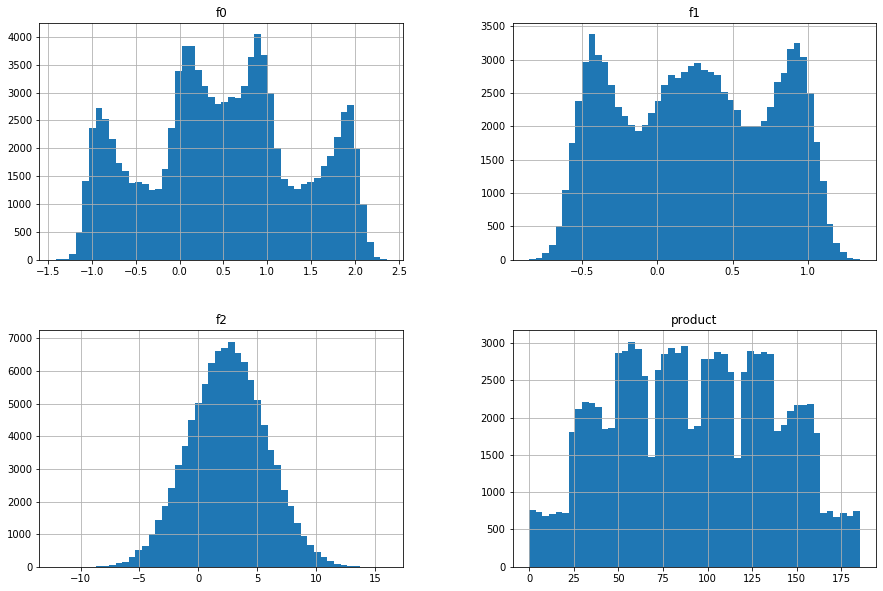

In [7]:
reg_0.hist(bins=50, figsize=(15, 10))

        Многогорбые распределения.
        Пропусков в данных нет.
        Есть дубликаты ID скважин, нужно их удалить.

In [8]:
reg_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [9]:
reg_1.duplicated().sum()

0

In [10]:
reg_1['id'].duplicated().sum()

4

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc884259650>,
      dtype=object)

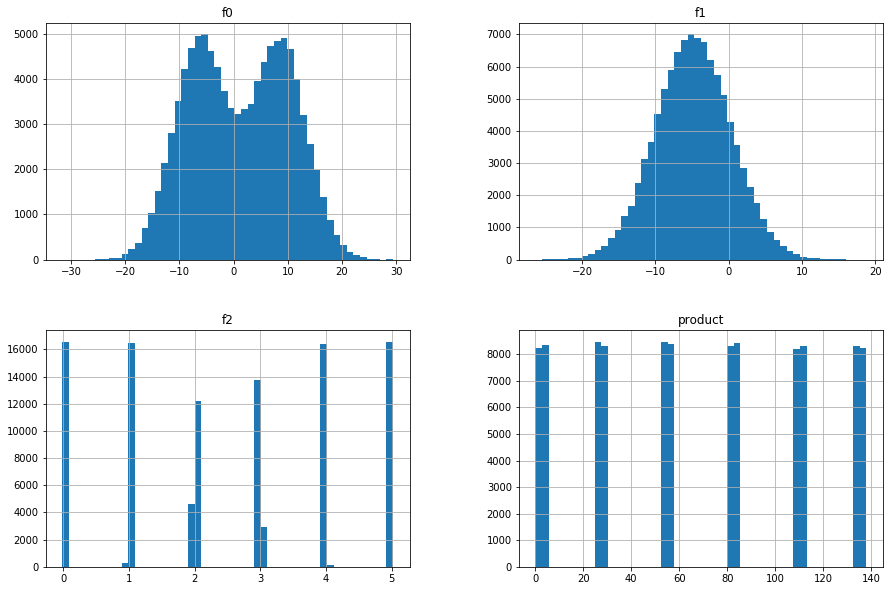

In [11]:
reg_1.hist(bins=50, figsize=(15, 10))

In [12]:
reg_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [13]:
reg_2.duplicated().sum()

0

In [14]:
reg_2['id'].duplicated().sum()

4

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc88a5d7e90>,
      dtype=object)

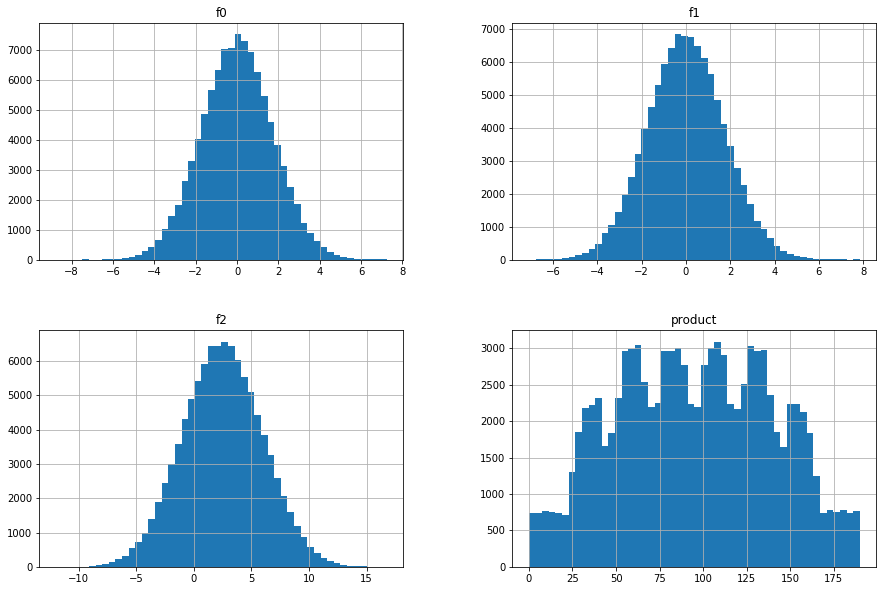

In [15]:
reg_2.hist(bins=50, figsize=(15, 10))

    Мы увидели разные распределения.
    Засекли повторы в ID скважин, но их крайне малое значение, максимум - 10шт. в регионе 1. Поэтому их даже можно не удалять.

В дальнейшей работе нам не понадобятся ID скважин, и более того, нам нужны данные сторого без ID, поэтому удалим их, сохранив в новой переменной остаток.

In [16]:
df_0 = reg_0.drop('id', axis=1)
df_1 = reg_1.drop('id', axis=1)
df_2 = reg_2.drop('id', axis=1)

# 2. Обучение и проверка модели

    В этом шаге мы обучим и проверим модели для каждого региона.
    Сохраним предсказания наших моделей на валидационной выборке.

__1.__

В этом шаге мы напишем функцию - few_steps_in_one(), которая сможет совместить в себе несколько этапов:

    1. выделит целевое значение от остальных признаков.
    2. разделит данные на обучающую и валидационную выборки в соотношении 75 к 25ю
    3. обучит модель.
    
Моделью выберем - линейную регрессию, линейную, т.к. имеем дело с числами, а не с категориальными данными, регрессию - как наиболее предсказуемая.

    4. вернёт прогноз и верные ("таргетные") значения.
    5. а также нужные для оценки модели и предсказания метрики.
    
К ним относятся: метрика качества RMSE, и нужные нам для получения представления о регионе данные - средний запас сырья (предсказанный моделью - pred_mean_product и реальный - real_mean_product)

Соответственно, всё, что понадобится функции на вход - наши данные.

In [17]:
def split_train_valid(df):
    features = df.drop('product', axis=1)
    target = df['product']
    
    train_features, valid_features, train_target, valid_target = train_test_split(
    features, target, test_size=0.25, random_state=123)
    
    model = LinearRegression()
    model.fit(train_features, train_target)
    prediction = pd.Series(model.predict(valid_features))
    
    rmse = mean_squared_error(valid_target, prediction)**0.5
                           
    pred_mean_product= prediction.mean()
                           
    real_mean_product = valid_target.mean()
    
    return(prediction, valid_target.reset_index(drop=True), rmse, 
           pred_mean_product, real_mean_product) 

        для региона 1

In [18]:
pred_0, valid_target_0, rmse_0, pred_mean_product_0, real_mean_product_0 = split_train_valid(df_0)

        для региона 2

In [19]:
pred_1, valid_target_1, rmse_1, pred_mean_product_1, real_mean_product_1 = split_train_valid(df_1)

        для региона 3

In [20]:
pred_2, valid_target_2, rmse_2, pred_mean_product_2, real_mean_product_2 = split_train_valid(df_2)

__2.__

Cохраним полученные прогнозы с верными ответами. Понадобятся в дальнейшем, когда будем подсчитавать риски убытков и прибыль для компании.

In [21]:
answers_0 = pd.DataFrame()
answers_0['true_product'] = valid_target_0
answers_0['predict_product'] = pred_0

In [22]:
answers_1 = pd.DataFrame()
answers_1['true_product'] = valid_target_1
answers_1['predict_product'] = pred_1

In [23]:
answers_2 = pd.DataFrame()
answers_2['true_product'] = valid_target_2
answers_2['predict_product'] = pred_2

__3.__

Далее посмотрим на RMSE моделей и средний запас предсказанного сырья по регионам.

        средний запас сырья предсказанный моделью - pred_mean_product.
        
        средний запас сырья на самом деле - real_mean_product.

In [24]:
print('RMSE модели региона 1: {:0.2f}'.format(rmse_0))
print('средний запас сырья предсказанный моделью региона 1:', int(pred_mean_product_0))
print('средний запас сырья на самом деле региона 1: ', int(real_mean_product_0))

RMSE модели региона 1: 37.65
средний запас сырья предсказанный моделью региона 1: 92
средний запас сырья на самом деле региона 1:  92


In [25]:
print('RMSE модели региона 2: {:0.2f}'.format(rmse_1))
print('средний запас сырья предсказанный моделью региона 2:', int(pred_mean_product_1))
print('средний запас сырья на самом деле региона 2: ', int(real_mean_product_1))


RMSE модели региона 2: 0.90
средний запас сырья предсказанный моделью региона 2: 69
средний запас сырья на самом деле региона 2:  69


In [26]:
print('RMSE модели региона 3: {:0.2f}'.format(rmse_2))
print('средний запас сырья предсказанный моделью региона 3:', int(pred_mean_product_2))
print('средний запас сырья на самом деле региона 3: ', int(real_mean_product_2))

RMSE модели региона 3: 40.13
средний запас сырья предсказанный моделью региона 3: 95
средний запас сырья на самом деле региона 3:  94


Нас __больше интересует средний запас, нежели rmse__, т.к. прибыль будет больше там, где больше нефти.

Большне нефти в регионе 3 - 95тыс.баррелей его средний запас,и модель предсказалла 95.

Потом идёт регион 1 со средним запасом в 92тыс.баррелей, и модель предсказала 92.

Замыкает ряд регион 3 со средним запасом - 69 тыс.баррелей, модель предсказала 69.

Но самая низкая, а чем ниже, тем лучше, rmse модели второго региона, предсказанные данные по второму региону из всех прогнозов наиболее близки к реальности..

# 3. Подготовка к расчёту прибыли

__1.__

Сохраним ключевые значения для расчётов в отдельных переменных.

        Бюджет на регион (budget) = 10 млрд.руб

In [27]:
BUDGET = 10000000000

        Планируемое количество разрабатываемых скважин (wells) = 200 скважин в регионе.

In [28]:
WELLS = 200

        Стоимость 1 тыс.баррелей нефти (cost_1000) = 450 тыс.руб.

In [29]:
COST_1000 = 450000

__2.__

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. 

Сравним полученный объём сырья со средним запасом в каждом регионе.

__Бюджет__ каждого региона - __10 млрд.руб.__ Планируется разработка 200 скважин. Значит каждая скважина должна приносить не меньшую потраченной на нее сумму прибыль, 

которую узнаем посчитав отношение бюджета к количеству планируемых скважин:

In [30]:
profit_1_well = BUDGET / WELLS
profit_1_well

50000000.0

Таким образом, чтобы не уйти в убыток и вложенные средства как-минимум вернулись, __одна скважина__ должна принести не менее __50 млн.руб.__

Зная, что __1 барелль__ нефти стоит __450 руб.__ рассчитаем минимальный запас нефти, который должен быть в скважине (min_reserve).

Для этого посмотрим на отношение минимальной прибыли скважины к стоимости 1 тысячи баррелей нефти

In [31]:
min_reserve = profit_1_well / COST_1000
min_reserve

111.11111111111111

Ясно, что нас интересуют скважины,по прогнозу в которых хранится не менее 112 тыс.баррелей, чтобы не уйти в убыточное производство.

                                    ***

Сравним полученный объём сырья со средним запасом в каждом регионе.

In [32]:
print("Средний запас в регионе 1 : {:0.0f}".format(pred_mean_product_0))
print("Средний запас в регионе 2 : {:0.0f}".format(pred_mean_product_1))
print("Средний запас в регионе 3 : {:0.0f}".format(pred_mean_product_2))
print("Необходимое количество нефти для окупаемости : {:0.1f}".format(min_reserve))

Средний запас в регионе 1 : 93
Средний запас в регионе 2 : 69
Средний запас в регионе 3 : 95
Необходимое количество нефти для окупаемости : 111.1


Средний запас в регионах меньше необходимого, но не стоит паниковать, ведь это средний запас....

Предлогаю сравнить не со средним, а с распределением на гистограмме:

        предсказания модели относительно запасов в регионе 1:

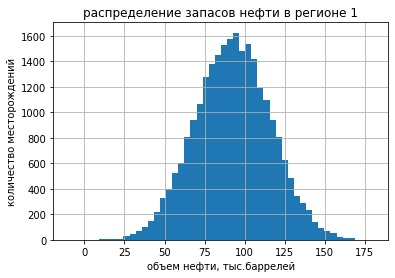

In [33]:
answers_0['predict_product'].hist(bins=50)
plt.title("распределение запасов нефти в регионе 1"); 
plt.xlabel("объем нефти, тыс.баррелей")
plt.ylabel("количество месторождений")
plt.show()

In [34]:
answers_0['predict_product'].describe()

count    25000.000000
mean        92.549362
std         23.417413
min         -9.834307
25%         76.555717
50%         92.687630
75%        108.463616
max        180.192010
Name: predict_product, dtype: float64

        предсказания модели относительно запасов в регионе 2:

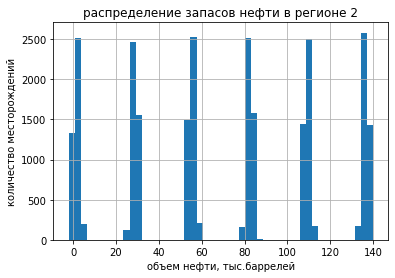

In [35]:
answers_1['predict_product'].hist(bins=50)
plt.title("распределение запасов нефти в регионе 2"); 
plt.xlabel("объем нефти, тыс.баррелей")
plt.ylabel("количество месторождений")
plt.show()

In [36]:
answers_1['predict_product'].describe()

count    25000.000000
mean        69.280019
std         45.819890
min         -2.066353
25%         28.689663
50%         79.987224
75%        109.351179
max        139.906443
Name: predict_product, dtype: float64

        предсказания модели относительно запасов в регионе 3:

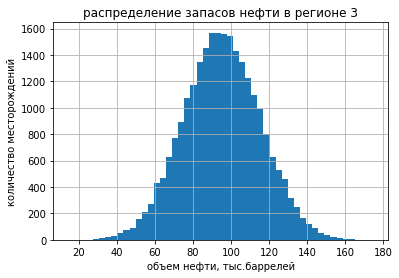

In [37]:
answers_2['predict_product'].hist(bins=50)
plt.title("распределение запасов нефти в регионе 3"); 
plt.xlabel("объем нефти, тыс.баррелей")
plt.ylabel("количество месторождений")
plt.show()

In [38]:
answers_2['predict_product'].describe()

count    25000.000000
mean        95.098599
std         20.175789
min         14.590694
25%         81.398949
50%         94.929589
75%        108.821916
max        174.573336
Name: predict_product, dtype: float64

На графиках трёх регионов мы видим, что в достаточном количестве встречаются месторождения с запасом более 120 тыс.баррелей.

Теперь нас не пугает недостаточное среднее. Главное, чтоб модель верно строила прогноз.

# 4. Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели

В этом шаге мы:


Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели.


        Функция для расчёта прибыли - сумма всех тысяч баррелей нефти предсказанная (или реальная), которые может добыть кампания, разрабатывая известные месторождения, умноженная на стоимость одной тысячи баррелей из чего вычитается бюджет. 

In [39]:
def general_profit(summ_barrels):
    return(int((sum(summ_barrels) * COST_1000) - BUDGET))

        Функцимя для расчета средней прибыли:

In [40]:
def general_mean_profit(series):
    return(series.mean())

__4.1.__

Выберем скважины с максимальными значениями предсказаний. Количество скважин зависит от бюджета компании и стоимости разработки одной скважины.


В шаге три мы обговорили, что бюджет на разработку 1 скважины = 50млн.руб., а бюджет на весь регион - 10 млрд.руб., то есть на разработку 200 скважин.

        топ 200 скважин района 1:

In [41]:
top_0 = sorted(pred_0, reverse=True)

In [42]:
top_0 = top_0[0:200]

        топ 200 скважин района 2:

In [43]:
top_1 = sorted(pred_1, reverse=True)

In [44]:
top_1 = top_1[0:200]

        топ 200 скважин района 3:

In [45]:
top_2 = sorted(pred_2, reverse=True)

In [46]:
top_2 = top_2[0:200]

__4.2.__ 

Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям.

        сумма объема сырья региона 1:

In [47]:
summ_0 = sum(top_0)
summ_0

31034.787805093598

        сумма объема сырья региона 2:

In [48]:
summ_1 = sum(top_1)
summ_1

27755.76198279395

        сумма объема сырья региона 3:

In [49]:
summ_2 = sum(top_2)
summ_2

29943.44311039178

Самый перспективный регион - первый, далее - третий и замыкает - второй.

__4.3.__

Рассчитаем прибыль для полученного объёма сырья произведением суммы запасов в 200 сткважинах на стоимость тысячи баррелей (в рублях).

        прибыль в регионе 1:

In [50]:
sum_profit_0 = general_profit(top_0)
sum_profit_0

3965654512

        прибыль в регионе 2:

In [51]:
sum_profit_1 = general_profit(top_1)
sum_profit_1

2490092892

        прибыль в регионе 3:

In [52]:
sum_profit_2 = general_profit(top_2)
sum_profit_2

3474549399

Теоретически: Самый перспективный регион - первый, далее - третий и замыкает - второй.

С каким регионом будет работать кампания - узнаем в шаге 5.

# 5. Подсчёт рисков и прибыли для каждого региона

Общий план таков:

Согласно Центральной Предельной Теореме случайная выборка имеет свойства генеральной совокупности.

Поэтому методом Bootstrap мы создадим 1000 случайных выборок по 500 объектов из общего датафрейма, отсортируем датафрейм по предсказанным значениям от большего к меньшему и возьмем из него первые 200 значений "действительного запаса нефти" (НЕ предсказанного, а "таргетного"). 

Посчитаем прибыль и сохраним данные в список ``values``.

Далее найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков.


__5.1.__

Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.

In [53]:
def get_values(data):
    values = []
    state = np.random.RandomState(12345)
    for i in range(1000):
        subsampling = data.sample(n=500, replace=True, random_state=state)
        subsampling = subsampling.sort_values(by='predict_product', ascending=False).reset_index(drop=True)
        selected_wells = subsampling.loc[0:(WELLS - 1), 'true_product']      
        profit = general_profit(selected_wells)
        values.append(profit)
    values = pd.Series(values)
    return(values)

Данные, которые мы получили в шаге 2 - хранятся в датафрейме answers, в столбце 'predict_product' - предсказанные на валидационной выборке значения запасов нефти, в столбце 'true_product' - таргетные значения.

In [54]:
values_0 = get_values(answers_0)

In [55]:
answers_0.loc[0:WELLS - 1]

,true_product,predict_product
0,145.825972,123.284256
1,134.020212,75.838240
2,88.905826,55.526760
3,19.508226,86.673045
4,108.713468,109.909327
...,...,...
195,122.662279,107.438498
196,67.054045,80.291796
197,148.655849,71.747691
198,117.784324,90.083788


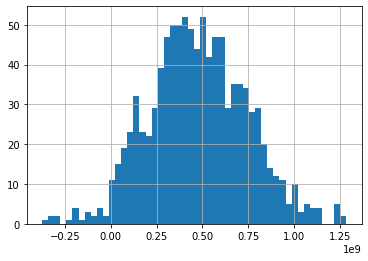

In [56]:
values_0.hist(bins=50)

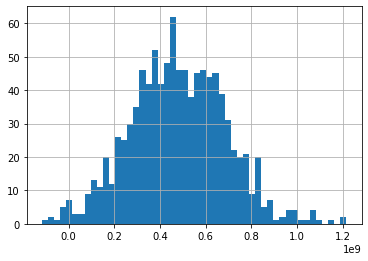

In [57]:
values_1 = get_values(answers_1)
values_1.hist(bins=50)

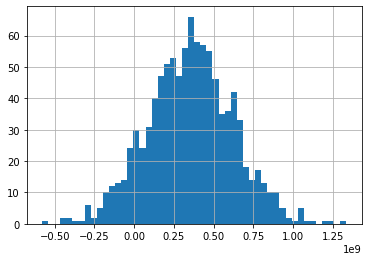

In [58]:
values_2 = get_values(answers_2)
values_2.hist(bins=50)

In [59]:
values_2.sum()

353155921700

Оценивая распределеиня, можно сказать, что наша модель справляется, причем оптимальней всего - в регионе 2, где rmse = 0.8, самая низкая.

__5.2.__

Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.

Автоматизируем процесс, что позволит сократить объем кода и его дубликацию:

In [60]:
def get_conf_int(values):
    lover = int(values.quantile(0.025))
    upper = int(values.quantile(0.975))
    mean_prof = int(values.mean())
    median_prof = int(values.median())
    confidence_interval = st.t.interval(alpha = 0.95, df=(len(values)-1),
                                        loc=values.mean(), scale=values.sem())
    risc = 0
    count_negative = 0
    for i in range(len(values)):
        if values[i] < 0:
            count_negative += 1
        risc = abs(count_negative / len(values))
    print('Средняя выручка: ', mean_prof)
    print('Медиана распределения выручки: ', median_prof)
    print('2,7% - квантиль: ', lover)
    print('97.5% - квантиль: ', upper)
    print('Доверительный интервал: ', confidence_interval)
    print('Риск убытков: {:0.1f}% '.format(risc * 100))

In [61]:
print('Регион 1')
print()
get_conf_int(values_0)

Регион 1

Средняя выручка:  476303228
Медиана распределения выручки:  469799721
2,7% - квантиль:  4800798
97.5% - квантиль:  1008423975
Доверительный интервал:  (459787858.83432347, 492818599.0696766)
Риск убытков: 2.5% 


In [62]:
print('Регион 2')
print()
get_conf_int(values_1)

Регион 2

Средняя выручка:  480214032
Медиана распределения выручки:  474109803
2,7% - квантиль:  83026797
97.5% - квантиль:  890027646
Доверительный интервал:  (467293087.95712936, 493134976.5868707)
Риск убытков: 1.1% 


In [63]:
print('Регион 3')
print()
get_conf_int(values_2)

Регион 3

Средняя выручка:  353155921
Медиана распределения выручки:  352759951
2,7% - квантиль:  -178067459
97.5% - квантиль:  897086216
Доверительный интервал:  (336287830.2024933, 370024013.19750667)
Риск убытков: 9.6% 


__5.3.__

__Вывод:__ предложим регион для разработки скважин и обоснуем выбор.

Сразу отказываемся от разработки первого и третьего региона, т.к. риск понести компанией убытки составляет 2,5% и 9,6% соответственно, не смотря на то, что третий регион - лидер по запасам сырья, а первый едва уступает ему. НО rmse модели третьего и первого региона высоки = 40 и 37, что делает прогноз модели не всегда соответствующим действительности.

Однозначно рекомендуем к выбору второй регион для разработки.

Таким образом, на практике был выбран второй регион, который с самым низким запасом сырья = 69 против 95 и 93 в третьем и первом регионах, НО самой точной моделью, ее rmse = 0.9, против первого региона = 37 и третьего = 40. Третий стал самым убыточным. То есть можно сказать, что точность предсказания важней запасов сырья, т.к. будут выбраны месторождения с максимальным запасом сырья с бОльшей вероятность.